# <u>CIFAR10 Classification Using CNN in PyTorch</u>
#### <u>Daniel Arama</u>
<br>

#### Imports

In [124]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader
import torch.nn.functional as F


import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
seed = 42
np.random.seed(seed)

#Splitting the train set into train and validation
indices = np.random.permutation(len(trainset))
valid_size = 0.2

num_samples = len(trainset)
num_valid = int(valid_size * num_samples)
num_train = num_samples - num_valid

train_indices = indices[:num_train]
valid_indices = indices[num_train:]

train_subset = Subset(trainset, train_indices)
valid_subset = Subset(trainset, valid_indices)

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=len(train_subset))

validloader = torch.utils.data.DataLoader(valid_subset, batch_size=len(valid_subset))

testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset))

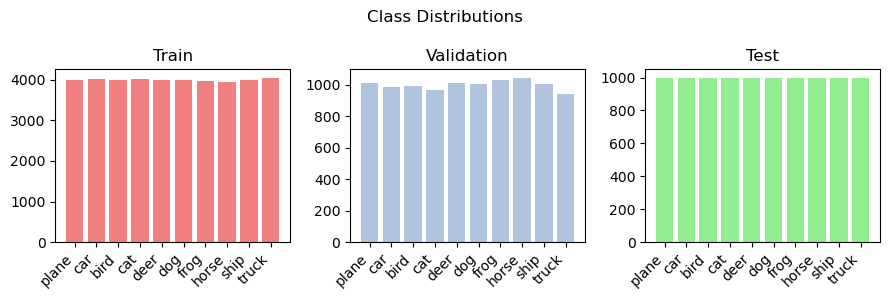

In [4]:
loaders = [trainloader, validloader, testloader]
titles =  ["Train","Validation","Test"]
colors =["lightcoral","lightsteelblue","lightgreen"]

fig, axes = plt.subplots(1, len(loaders), figsize=(len(loaders)*3, 3)) 
fig.suptitle("Class Distributions")
for idx, loader in enumerate(loaders):
    class_count = [0] * 10
    for _, labels in loader:
        for label in labels.numpy():
            class_count[label] += 1

    axes[idx].bar(classes, class_count, color=colors[idx])
    axes[idx].set_title(titles[idx])
    axes[idx].set_xticks(range(len(classes)))
    axes[idx].set_xticklabels(classes, rotation=45, ha='right')

plt.tight_layout()  
plt.show()

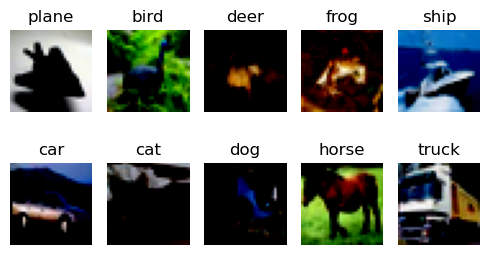

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes_num = range(0,10)
samples = []
for i in classes_num:
    for idx, (image, label) in enumerate(trainset):
        if i == label:
            samples.append(idx)
            break
            
fig, axes = plt.subplots(2, 5, figsize=(5, 3))
for idx, sample_idx in enumerate(samples):
    img, label = trainset[sample_idx]
    col = idx // 2
    row = idx % 2
    ax = axes[row, col]
    ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    ax.set_title(classes[label])
    ax.axis('off')
fig.tight_layout()
clear_output();
plt.show()

In [6]:
def loss_vis(loss_1, loss_2, label_1, label_2, title):
    epochs = range(1, len(loss_1) + 1)
    plt.plot(epochs, [loss.item() for loss in loss_1], label=label_1, color='firebrick')
    plt.plot(epochs, [loss.item() for loss in loss_2], label=label_2, color='mediumblue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

In [7]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [8]:
def ModelTraining(model_name, batch_size, lr, l2, patience=5, epochs_per_print = 5, num_epochs = 50):
    
    model = model_name
             
    #Lists of loss per epoch
    train_losses = []
    valid_losses = []
    
    #Loaders
    validloader = torch.utils.data.DataLoader(valid_subset, batch_size=len(valid_subset))
    trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    
    #Size of train subset
    train_set_size = len(train_subset)

    #Loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=l2)
    
    #Early stopping improvment constant 
    best_valid_loss = float('inf')
    epochs_no_improve = 0
    best_valid_acc = 0
    
    #Training loop
    for epoch in range(num_epochs):

        model.train()
        total_loss_train = 0
        
        for batch_idx, (data, target) in enumerate(trainloader):

            output_train = model(data)
            loss_train = loss_fn(output_train, target)
            total_loss_train += loss_train
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            
        #Train loss average in current epoch
        total_loss_train /= (train_set_size/batch_size)
        train_losses.append(total_loss_train)
        
        #Evaluation
        model.eval()
        with torch.inference_mode():
            
            #Accuracy and loss in valid
            for batch_idx, (data_valid, target_valid) in enumerate(validloader):
                output_valid = model(data_valid)
                pred_valid = torch.softmax(output_valid, dim=1).argmax(dim=1)
                loss_valid = loss_fn(output_valid, target_valid)
                acc_valid = accuracy_fn(target_valid, pred_valid)
                
            valid_losses.append(loss_valid)
            
            #Early stopping
            if loss_valid < best_valid_loss:
                best_valid_loss = loss_valid
                epochs_no_improve = 0
                
            else:
                epochs_no_improve += 1
                if epochs_no_improve == patience:
                    print(f'Early stopping at epoch {epoch}, with {best_valid_loss:.5f} validation loss')
                    break

        #Calculating train accuracy and printing whats happaning
        if epoch % epochs_per_print == 0 or num_epochs == epoch-1:
            
            #acc in train
            total_acc_train = 0
            for batch_idx, (data, target) in enumerate(trainloader):
                output_train = model(data)
                pred_train = torch.softmax(output_train, dim=1).argmax(dim=1)
                total_acc_train += accuracy_fn(target, pred_train)
                
            total_acc_train /= (train_set_size/batch_size)
            
            print(f"Epoch: {epoch} | Train Loss: {total_loss_train:.5f}, Train Acc: {total_acc_train:.2f}% |\
            Validation Loss: {loss_valid:.5f}, Validation Acc: {acc_valid:.2f}%")
            
    return train_losses, valid_losses

Given the example we reviewed in class using a CNN on the MNIST Fashion dataset, I am using a similar architecture with minor adjustments to fit the CIFAR10 dataset's image sizes and color channels.

In [52]:
class CNNNetwork1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=5)
        self.fc1 = nn.Linear(in_features=12*5*5,out_features=120)
        self.fc2 = nn.Linear(in_features=120,out_features=60)
        self.fc3 = nn.Linear(in_features=60,out_features=40)
        self.out = nn.Linear(in_features=40,out_features=10)
    def forward(self,x):
        #input layer
        x = x
        #first hidden layer
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        #second hidden layer
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        #third hidden layer
        x = x.reshape(-1,12*5*5)
        x = self.fc1(x)
        x = F.relu(x)
        #fourth hidden layer
        x = self.fc2(x)
        x = F.relu(x)
        #fifth hidden layer
        x = self.fc3(x)
        x = F.relu(x)
        #output layer
        x = self.out(x)
        return x

I have decided to try the model with the best hyperparameters I found in the previous project (MNIST Digit Using FCN).

Epoch: 0 | Train Loss: 2.30456, Train Acc: 14.77% |            Validation Loss: 2.30041, Validation Acc: 14.49%
Epoch: 5 | Train Loss: 1.56116, Train Acc: 40.06% |            Validation Loss: 1.64004, Validation Acc: 38.88%
Epoch: 10 | Train Loss: 1.27591, Train Acc: 55.38% |            Validation Loss: 1.30652, Validation Acc: 52.82%
Epoch: 15 | Train Loss: 1.11893, Train Acc: 61.14% |            Validation Loss: 1.22330, Validation Acc: 57.05%
Epoch: 20 | Train Loss: 0.99172, Train Acc: 65.47% |            Validation Loss: 1.16099, Validation Acc: 59.33%
Early stopping at epoch 23, with 1.15192 validation loss


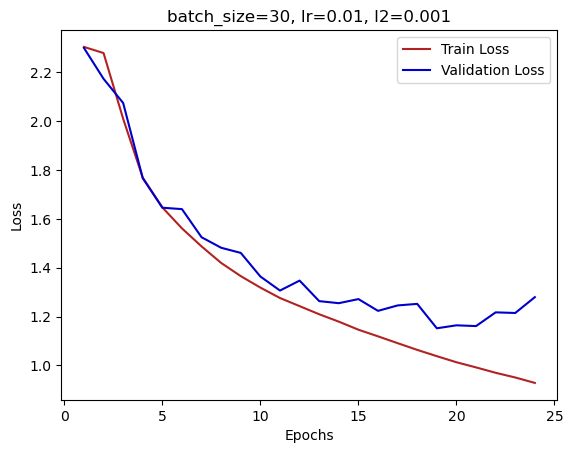

In [54]:
batch_size = 30
lr = 0.01 
l2 = 0.001
model = CNNNetwork1()
parameters_string = f"batch_size={batch_size}, lr={lr}, l2={l2}"
train_losses, valid_losses = ModelTraining(model, batch_size, lr, l2, num_epochs = 50)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)


Let's experiment with adding dropout to the fully connected layers and observe its effect on the model's performance.

In [59]:
class CNNNetwork2(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=5)
        self.fc1 = nn.Linear(in_features=12*5*5,out_features=120)
        self.fc2 = nn.Linear(in_features=120,out_features=60)
        self.fc3 = nn.Linear(in_features=60,out_features=40)
        self.out = nn.Linear(in_features=40,out_features=10)
        self.dropout = nn.Dropout(dropout)
    def forward(self,x):
        #input layer
        x = x
        #first hidden layer
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        #second hidden layer
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        #third hidden layer
        x = x.reshape(-1,12*5*5)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        #fourth hidden layer
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        #fifth hidden layer
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        #output layer
        x = self.out(x)
        return x

Epoch: 0 | Train Loss: 2.30405, Train Acc: 14.25% |            Validation Loss: 2.29986, Validation Acc: 14.03%
Epoch: 5 | Train Loss: 1.63382, Train Acc: 40.75% |            Validation Loss: 1.61665, Validation Acc: 40.73%
Epoch: 10 | Train Loss: 1.40699, Train Acc: 52.09% |            Validation Loss: 1.35222, Validation Acc: 50.35%
Epoch: 15 | Train Loss: 1.26948, Train Acc: 57.22% |            Validation Loss: 1.26243, Validation Acc: 54.38%
Epoch: 20 | Train Loss: 1.15454, Train Acc: 61.34% |            Validation Loss: 1.20843, Validation Acc: 57.64%
Epoch: 25 | Train Loss: 1.06366, Train Acc: 64.87% |            Validation Loss: 1.15218, Validation Acc: 59.52%
Epoch: 30 | Train Loss: 0.99263, Train Acc: 65.97% |            Validation Loss: 1.14762, Validation Acc: 59.53%
Epoch: 35 | Train Loss: 0.93504, Train Acc: 70.07% |            Validation Loss: 1.11115, Validation Acc: 61.40%
Epoch: 40 | Train Loss: 0.88645, Train Acc: 72.25% |            Validation Loss: 1.09852, Validati

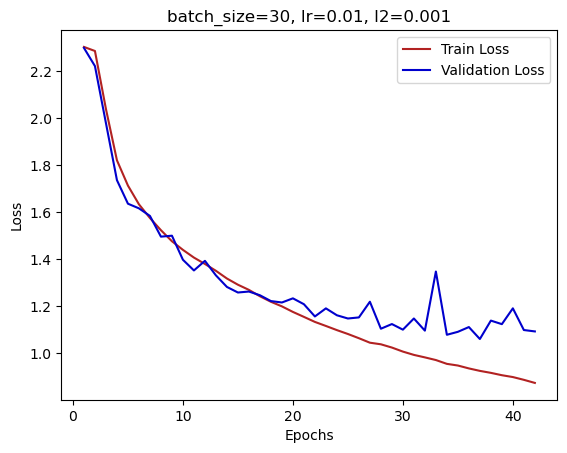

In [60]:
batch_size = 30
lr = 0.01 
l2 = 0.001
model = CNNNetwork2(0.1)
parameters_string = f"batch_size={batch_size}, lr={lr}, l2={l2}"
train_losses, valid_losses = ModelTraining(model, batch_size, lr, l2, num_epochs = 50)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Adding dropout to the fully connected layers has proven to improve our model.<br> Now, let's explore the impact of adding dropout to the convolutional layers as well.

In [64]:
class CNNNetwork3(nn.Module):
    def __init__(self, dropout_f, dropout_c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=5)
        self.fc1 = nn.Linear(in_features=12*5*5,out_features=120)
        self.fc2 = nn.Linear(in_features=120,out_features=60)
        self.fc3 = nn.Linear(in_features=60,out_features=40)
        self.out = nn.Linear(in_features=40,out_features=10)
        self.dropout_fcn = nn.Dropout(dropout_f)
        self.dropout_conv = nn.Dropout2d(dropout_c)
    def forward(self,x):
        #input layer
        x = x
        #first hidden layer
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = self.dropout_conv(x)
        #second hidden layer
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = self.dropout_conv(x)
        #third hidden layer
        x = x.reshape(-1,12*5*5)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout_fcn(x)
        #fourth hidden layer
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout_fcn(x)
        #fifth hidden layer
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout_fcn(x)
        #output layer
        x = self.out(x)
        return x

After researching online, I concluded that the most common values for fully connected network (FCN) dropout are around 0.5, while for convolutional neural network (CNN), it's around 0.2. Let's apply those dropout values in our model.

Epoch: 0 | Train Loss: 2.30524, Train Acc: 12.71% |            Validation Loss: 2.30261, Validation Acc: 12.33%
Epoch: 5 | Train Loss: 2.16229, Train Acc: 20.76% |            Validation Loss: 2.08897, Validation Acc: 20.49%
Epoch: 10 | Train Loss: 2.03435, Train Acc: 20.67% |            Validation Loss: 1.93473, Validation Acc: 20.74%
Epoch: 15 | Train Loss: 1.96434, Train Acc: 25.84% |            Validation Loss: 1.87885, Validation Acc: 25.77%
Epoch: 20 | Train Loss: 1.91602, Train Acc: 28.45% |            Validation Loss: 1.81800, Validation Acc: 28.17%
Epoch: 25 | Train Loss: 1.86911, Train Acc: 34.31% |            Validation Loss: 1.73952, Validation Acc: 34.08%
Epoch: 30 | Train Loss: 1.82482, Train Acc: 35.54% |            Validation Loss: 1.71293, Validation Acc: 35.70%
Epoch: 35 | Train Loss: 1.78695, Train Acc: 37.71% |            Validation Loss: 1.66226, Validation Acc: 36.77%
Epoch: 40 | Train Loss: 1.76775, Train Acc: 39.88% |            Validation Loss: 1.62720, Validati

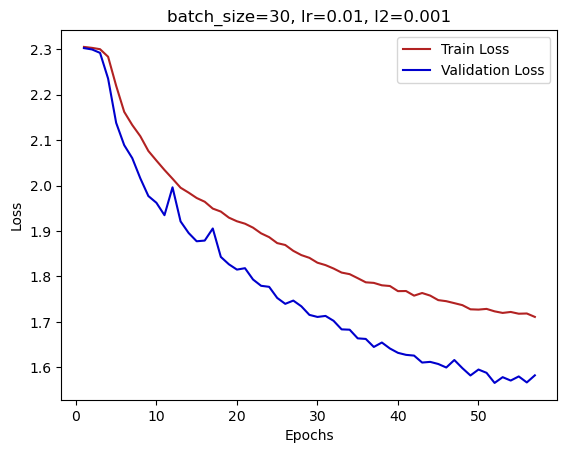

In [66]:
batch_size = 30
lr = 0.01 
l2 = 0.001
model = CNNNetwork3(0.5, 0.2)
parameters_string = f"batch_size={batch_size}, lr={lr}, l2={l2}"
train_losses, valid_losses = ModelTraining(model, batch_size, lr, l2, num_epochs = 100)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Let's further decrease the dropout rate and observe its impact on the model's performance.

Epoch: 0 | Train Loss: 2.30566, Train Acc: 10.65% |            Validation Loss: 2.30178, Validation Acc: 10.49%
Epoch: 5 | Train Loss: 2.04525, Train Acc: 26.56% |            Validation Loss: 1.93658, Validation Acc: 26.50%
Epoch: 10 | Train Loss: 1.86712, Train Acc: 34.04% |            Validation Loss: 1.74989, Validation Acc: 33.78%
Epoch: 15 | Train Loss: 1.77035, Train Acc: 41.89% |            Validation Loss: 1.63279, Validation Acc: 41.10%
Epoch: 20 | Train Loss: 1.69658, Train Acc: 46.27% |            Validation Loss: 1.54198, Validation Acc: 45.12%
Epoch: 25 | Train Loss: 1.64677, Train Acc: 48.10% |            Validation Loss: 1.47805, Validation Acc: 47.20%
Epoch: 30 | Train Loss: 1.60973, Train Acc: 49.58% |            Validation Loss: 1.47755, Validation Acc: 47.97%
Epoch: 35 | Train Loss: 1.58216, Train Acc: 51.46% |            Validation Loss: 1.42523, Validation Acc: 49.09%
Epoch: 40 | Train Loss: 1.56403, Train Acc: 53.61% |            Validation Loss: 1.39846, Validati

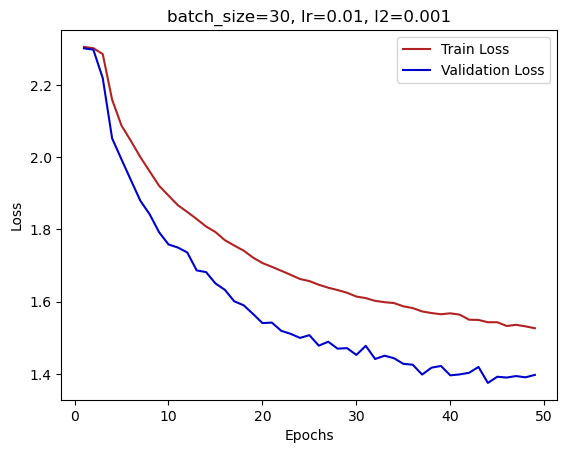

In [67]:
batch_size = 30
lr = 0.01 
l2 = 0.001
model = CNNNetwork3(0.3, 0.2)
parameters_string = f"batch_size={batch_size}, lr={lr}, l2={l2}"
train_losses, valid_losses = ModelTraining(model, batch_size, lr, l2, num_epochs = 100)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Let's try to decrease it even more

Epoch: 0 | Train Loss: 2.30543, Train Acc: 10.14% |            Validation Loss: 2.30277, Validation Acc: 9.43%
Epoch: 5 | Train Loss: 1.95341, Train Acc: 34.32% |            Validation Loss: 1.81489, Validation Acc: 35.10%
Epoch: 10 | Train Loss: 1.71017, Train Acc: 44.51% |            Validation Loss: 1.57611, Validation Acc: 43.75%
Epoch: 15 | Train Loss: 1.60963, Train Acc: 49.42% |            Validation Loss: 1.46675, Validation Acc: 48.43%
Epoch: 20 | Train Loss: 1.54261, Train Acc: 52.04% |            Validation Loss: 1.39138, Validation Acc: 50.33%
Epoch: 25 | Train Loss: 1.49158, Train Acc: 54.24% |            Validation Loss: 1.36568, Validation Acc: 51.73%
Epoch: 30 | Train Loss: 1.44286, Train Acc: 54.93% |            Validation Loss: 1.35699, Validation Acc: 52.19%
Epoch: 35 | Train Loss: 1.40704, Train Acc: 59.75% |            Validation Loss: 1.27075, Validation Acc: 56.03%
Epoch: 40 | Train Loss: 1.37034, Train Acc: 60.35% |            Validation Loss: 1.25408, Validatio

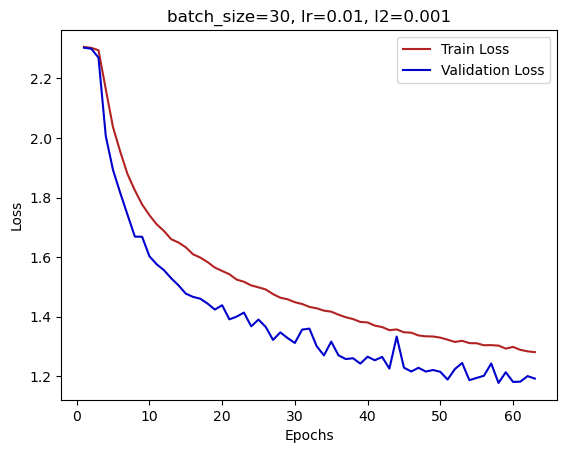

In [74]:
batch_size = 30
lr = 0.01 
l2 = 0.001
model = CNNNetwork3(0.1, 0.2)
parameters_string = f"batch_size={batch_size}, lr={lr}, l2={l2}"
train_losses, valid_losses = ModelTraining(model, batch_size, lr, l2, num_epochs = 100)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

It seems that adding dropout to the convolutional layers didn't improve the model, possibly because the model isn't complex enough to benefit from dropout regularization. Let's experiment with increasing the number of filters in the convolutional layers to enhance the model's complexity and observe if it leads to performance improvement.
Also Let's try to drop the filter kernel size to 3X3, and remove 2 fully connected layers.

In [77]:
class CNNNetwork4(nn.Module):
    def __init__(self, dropout_f, dropout_c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc = nn.Linear(in_features=64*4*4,out_features=60)
        self.out = nn.Linear(in_features=60,out_features=10)
        self.dropout_fcn = nn.Dropout(dropout_f)
        self.dropout_conv = nn.Dropout2d(dropout_c)
    def forward(self,x):
        #input layer
        x = x
        #first hidden layer
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = self.dropout_conv(x)
        #second hidden layer
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = self.dropout_conv(x)
        #third hidden layer
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = self.dropout_conv(x)
        #fourth hidden layer
        x = x.reshape(-1,64*4*4)
        x = self.fc(x)
        x = F.relu(x)
        x = self.dropout_fcn(x)
        #output layer
        x = self.out(x)
        return x

Epoch: 0 | Train Loss: 2.20635, Train Acc: 30.07% |            Validation Loss: 1.99822, Validation Acc: 30.70%
Epoch: 5 | Train Loss: 1.51516, Train Acc: 51.28% |            Validation Loss: 1.38825, Validation Acc: 50.31%
Epoch: 10 | Train Loss: 1.29988, Train Acc: 60.27% |            Validation Loss: 1.18403, Validation Acc: 58.35%
Epoch: 15 | Train Loss: 1.15854, Train Acc: 65.33% |            Validation Loss: 1.06561, Validation Acc: 62.62%
Epoch: 20 | Train Loss: 1.05936, Train Acc: 69.64% |            Validation Loss: 0.97898, Validation Acc: 65.56%
Epoch: 25 | Train Loss: 0.98534, Train Acc: 73.06% |            Validation Loss: 0.90107, Validation Acc: 67.96%
Epoch: 30 | Train Loss: 0.93260, Train Acc: 76.17% |            Validation Loss: 0.85745, Validation Acc: 70.16%
Epoch: 35 | Train Loss: 0.88718, Train Acc: 77.31% |            Validation Loss: 0.83468, Validation Acc: 70.58%
Epoch: 40 | Train Loss: 0.85638, Train Acc: 78.98% |            Validation Loss: 0.81074, Validati

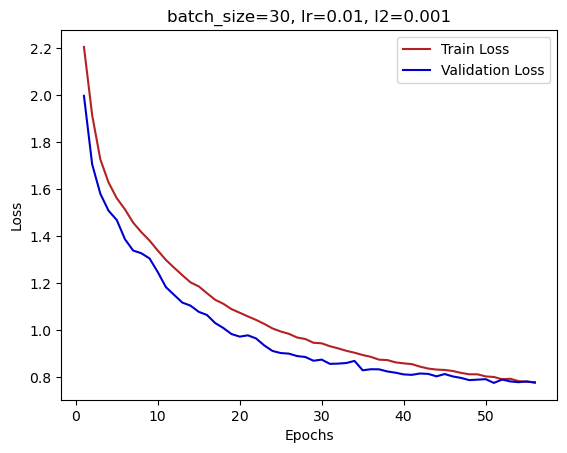

In [78]:
batch_size = 30
lr = 0.01 
l2 = 0.001
model = CNNNetwork4(0.1, 0.2)
parameters_string = f"batch_size={batch_size}, lr={lr}, l2={l2}"
train_losses, valid_losses = ModelTraining(model, batch_size, lr, l2, num_epochs = 100)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

It's clear that adding more filters to the model has been beneficial. Let's build upon this by further increasing the number of filters to enhance the model's performance. Additionally, we can introduce one more fully connected layer and increase the dropout rate for the fully connected layers to 0.2.

In [81]:
class CNNNetwork5(nn.Module):
    def __init__(self, dropout_f, dropout_c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=128*4*4,out_features=512)
        self.fc2 = nn.Linear(in_features=512,out_features=64)
        self.out = nn.Linear(in_features=64,out_features=10)
        self.dropout_fcn = nn.Dropout(dropout_f)
        self.dropout_conv = nn.Dropout2d(dropout_c)
    def forward(self,x):
        #input layer
        x = x
        #first hidden layer
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = self.dropout_conv(x)
        #second hidden layer
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = self.dropout_conv(x)
        #third hidden layer
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = self.dropout_conv(x)
        #fourth hidden layer
        x = x.reshape(-1,128*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout_fcn(x)
        #fifth hidden layer
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout_fcn(x)
        #output layer
        x = self.out(x)
        return x

Epoch: 0 | Train Loss: 2.30129, Train Acc: 12.20% |            Validation Loss: 2.29049, Validation Acc: 11.63%
Epoch: 5 | Train Loss: 1.57437, Train Acc: 47.10% |            Validation Loss: 1.49040, Validation Acc: 46.54%
Epoch: 10 | Train Loss: 1.32330, Train Acc: 59.14% |            Validation Loss: 1.18801, Validation Acc: 57.51%
Epoch: 15 | Train Loss: 1.11685, Train Acc: 67.52% |            Validation Loss: 1.01638, Validation Acc: 64.82%
Epoch: 20 | Train Loss: 0.96428, Train Acc: 73.12% |            Validation Loss: 0.89315, Validation Acc: 68.97%
Epoch: 25 | Train Loss: 0.84419, Train Acc: 77.21% |            Validation Loss: 0.83359, Validation Acc: 70.84%
Epoch: 30 | Train Loss: 0.75123, Train Acc: 82.44% |            Validation Loss: 0.76361, Validation Acc: 72.98%
Epoch: 35 | Train Loss: 0.66391, Train Acc: 86.28% |            Validation Loss: 0.73690, Validation Acc: 74.75%
Epoch: 40 | Train Loss: 0.58342, Train Acc: 90.13% |            Validation Loss: 0.70381, Validati

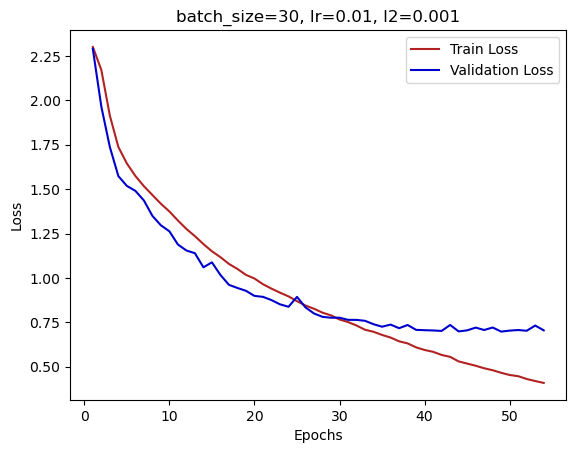

In [82]:
batch_size = 30
lr = 0.01 
l2 = 0.001
model = CNNNetwork5(0.2, 0.2)
parameters_string = f"batch_size={batch_size}, lr={lr}, l2={l2}"
train_losses, valid_losses = ModelTraining(model, batch_size, lr, l2, num_epochs = 100)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Let's add batch normalization

In [84]:
class CNNNetwork6(nn.Module):
    def __init__(self, dropout_f, dropout_c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(in_features=128*4*4,out_features=512)
        self.fc2 = nn.Linear(in_features=512,out_features=64)
        self.out = nn.Linear(in_features=64,out_features=10)
        self.dropout_fcn = nn.Dropout(dropout_f)
        self.dropout_conv = nn.Dropout2d(dropout_c)
    def forward(self,x):
        #input layer
        x = x
        #first hidden layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = self.dropout_conv(x)
        #second hidden layer
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = self.dropout_conv(x)
        #third hidden layer
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = self.dropout_conv(x)
        #fourth hidden layer
        x = x.reshape(-1,128*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout_fcn(x)
        #fifth hidden layer
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout_fcn(x)
        #output layer
        x = self.out(x)
        return x

Epoch: 0 | Train Loss: 1.82679, Train Acc: 47.14% |            Validation Loss: 1.47447, Validation Acc: 46.88%
Epoch: 5 | Train Loss: 1.12651, Train Acc: 68.48% |            Validation Loss: 0.96665, Validation Acc: 65.31%
Epoch: 10 | Train Loss: 0.92433, Train Acc: 73.85% |            Validation Loss: 0.85792, Validation Acc: 68.87%
Epoch: 15 | Train Loss: 0.79430, Train Acc: 80.72% |            Validation Loss: 0.73015, Validation Acc: 74.59%
Epoch: 20 | Train Loss: 0.69790, Train Acc: 84.27% |            Validation Loss: 0.69329, Validation Acc: 75.67%
Epoch: 25 | Train Loss: 0.62140, Train Acc: 87.66% |            Validation Loss: 0.65859, Validation Acc: 77.19%
Epoch: 30 | Train Loss: 0.55833, Train Acc: 89.39% |            Validation Loss: 0.66420, Validation Acc: 77.46%
Epoch: 35 | Train Loss: 0.50121, Train Acc: 91.53% |            Validation Loss: 0.65206, Validation Acc: 77.93%
Epoch: 40 | Train Loss: 0.45044, Train Acc: 93.79% |            Validation Loss: 0.63089, Validati

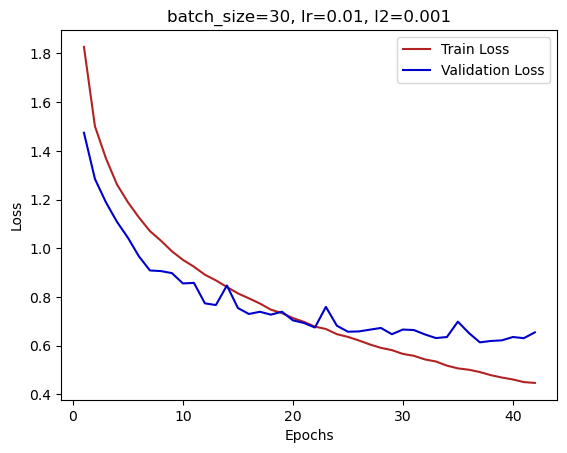

In [85]:
batch_size = 30
lr = 0.01 
l2 = 0.001
model = CNNNetwork6(0.2, 0.2)
parameters_string = f"batch_size={batch_size}, lr={lr}, l2={l2}"
train_losses, valid_losses = ModelTraining(model, batch_size, lr, l2, num_epochs = 100)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

## Data Augmentation

In [87]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./dataAg', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10(root='./dataAg', train=False, download=True, transform=transform_test)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


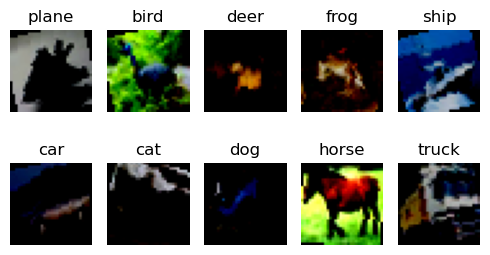

In [88]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes_num = range(0,10)
samples = []
for i in classes_num:
    for idx, (image, label) in enumerate(trainset):
        if i == label:
            samples.append(idx)
            break
            
fig, axes = plt.subplots(2, 5, figsize=(5, 3))
for idx, sample_idx in enumerate(samples):
    img, label = trainset[sample_idx]
    col = idx // 2
    row = idx % 2
    ax = axes[row, col]
    ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    ax.set_title(classes[label])
    ax.axis('off')
fig.tight_layout()
clear_output();
plt.show()

In [89]:
seed = 42
np.random.seed(seed)

#Splitting the train set into train and validation
indices = np.random.permutation(len(trainset))
valid_size = 0.2

num_samples = len(trainset)
num_valid = int(valid_size * num_samples)
num_train = num_samples - num_valid

train_indices = indices[:num_train]
valid_indices = indices[num_train:]

train_subset = Subset(trainset, train_indices)
valid_subset = Subset(trainset, valid_indices)

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=len(train_subset))

validloader = torch.utils.data.DataLoader(valid_subset, batch_size=len(valid_subset))

testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset))

Epoch: 0 | Train Loss: 1.91878, Train Acc: 41.27% |            Validation Loss: 1.61613, Validation Acc: 41.01%
Epoch: 5 | Train Loss: 1.30559, Train Acc: 59.93% |            Validation Loss: 1.14561, Validation Acc: 58.97%
Epoch: 10 | Train Loss: 1.12706, Train Acc: 66.59% |            Validation Loss: 0.98631, Validation Acc: 64.66%
Epoch: 15 | Train Loss: 1.02551, Train Acc: 69.89% |            Validation Loss: 0.91645, Validation Acc: 68.01%
Epoch: 20 | Train Loss: 0.95598, Train Acc: 72.17% |            Validation Loss: 0.87583, Validation Acc: 69.52%
Epoch: 25 | Train Loss: 0.89780, Train Acc: 75.77% |            Validation Loss: 0.76654, Validation Acc: 72.82%
Epoch: 30 | Train Loss: 0.84982, Train Acc: 75.83% |            Validation Loss: 0.77533, Validation Acc: 72.65%
Epoch: 35 | Train Loss: 0.81158, Train Acc: 77.72% |            Validation Loss: 0.73668, Validation Acc: 74.39%
Epoch: 40 | Train Loss: 0.77953, Train Acc: 79.02% |            Validation Loss: 0.71740, Validati

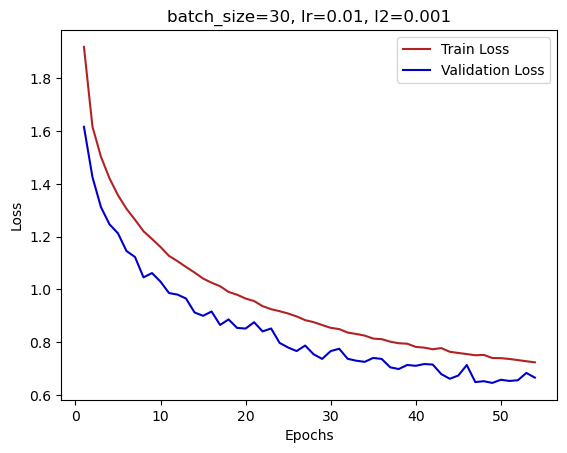

In [90]:
batch_size = 30
lr = 0.01 
l2 = 0.001
model = CNNNetwork6(0.2, 0.2)
parameters_string = f"batch_size={batch_size}, lr={lr}, l2={l2}"
train_losses, valid_losses = ModelTraining(model, batch_size, lr, l2, num_epochs = 100)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

It appears that the model struggled to learn, which suggests that it may not be complex enough. To address this, let's increase the number of filters in the convolutional layers.

In [91]:
class CNNNetwork7(nn.Module):
    def __init__(self, dropout_f, dropout_c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(in_features=256*4*4,out_features=512)
        self.fc2 = nn.Linear(in_features=512,out_features=64)
        self.out = nn.Linear(in_features=64,out_features=10)
        self.dropout_fcn = nn.Dropout(dropout_f)
        self.dropout_conv = nn.Dropout2d(dropout_c)
    def forward(self,x):
        #input layer
        x = x
        #first hidden layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = self.dropout_conv(x)
        #second hidden layer
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = self.dropout_conv(x)
        #third hidden layer
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = self.dropout_conv(x)
        #fourth hidden layer
        x = x.reshape(-1,256*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout_fcn(x)
        #fifth hidden layer
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout_fcn(x)
        #output layer
        x = self.out(x)
        return x

Epoch: 0 | Train Loss: 1.84309, Train Acc: 41.43% |            Validation Loss: 1.58976, Validation Acc: 41.79%
Epoch: 5 | Train Loss: 1.19011, Train Acc: 63.81% |            Validation Loss: 1.05185, Validation Acc: 63.20%
Epoch: 10 | Train Loss: 1.00968, Train Acc: 68.50% |            Validation Loss: 0.93641, Validation Acc: 66.16%
Epoch: 15 | Train Loss: 0.89511, Train Acc: 72.87% |            Validation Loss: 0.85123, Validation Acc: 70.27%
Epoch: 20 | Train Loss: 0.82567, Train Acc: 77.24% |            Validation Loss: 0.74026, Validation Acc: 73.72%
Epoch: 25 | Train Loss: 0.76442, Train Acc: 79.07% |            Validation Loss: 0.70284, Validation Acc: 75.52%
Epoch: 30 | Train Loss: 0.71334, Train Acc: 81.20% |            Validation Loss: 0.65635, Validation Acc: 77.20%
Early stopping at epoch 34, with 0.64189 validation loss


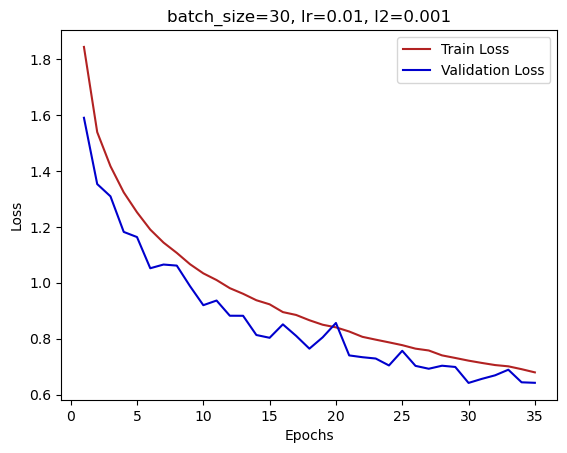

In [92]:
batch_size = 30
lr = 0.01 
l2 = 0.001
model = CNNNetwork7(0.2, 0.2)
parameters_string = f"batch_size={batch_size}, lr={lr}, l2={l2}"
train_losses, valid_losses = ModelTraining(model, batch_size, lr, l2, num_epochs = 100)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

It's apparent that despite the longer training time, the loss isn't showing improvement. The use of data augmentation appears to be complicating the learning process, as evidenced by the lower validation loss compared to the training loss. To tackle this issue, let's consider reducing the L2 normalization and the dropout rate for the fully connected layers. Additionally, let's revert to the previous model configuration with fewer filters since it exhibited a faster training time while achieving a comparable validation loss. 

In [93]:
class CNNNetwork6(nn.Module):
    def __init__(self, dropout_f, dropout_c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(in_features=128*4*4,out_features=512)
        self.fc2 = nn.Linear(in_features=512,out_features=64)
        self.out = nn.Linear(in_features=64,out_features=10)
        self.dropout_fcn = nn.Dropout(dropout_f)
        self.dropout_conv = nn.Dropout2d(dropout_c)
    def forward(self,x):
        #input layer
        x = x
        #first hidden layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = self.dropout_conv(x)
        #second hidden layer
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = self.dropout_conv(x)
        #third hidden layer
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = self.dropout_conv(x)
        #fourth hidden layer
        x = x.reshape(-1,128*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout_fcn(x)
        #fifth hidden layer
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout_fcn(x)
        #output layer
        x = self.out(x)
        return x

Epoch: 0 | Train Loss: 1.86940, Train Acc: 43.51% |            Validation Loss: 1.55369, Validation Acc: 43.98%
Epoch: 5 | Train Loss: 1.24948, Train Acc: 61.75% |            Validation Loss: 1.11062, Validation Acc: 59.93%
Epoch: 10 | Train Loss: 1.07839, Train Acc: 66.69% |            Validation Loss: 0.99602, Validation Acc: 64.54%
Epoch: 15 | Train Loss: 0.97440, Train Acc: 72.50% |            Validation Loss: 0.86079, Validation Acc: 70.03%
Epoch: 20 | Train Loss: 0.89563, Train Acc: 75.13% |            Validation Loss: 0.79583, Validation Acc: 72.41%
Epoch: 25 | Train Loss: 0.83186, Train Acc: 76.63% |            Validation Loss: 0.76808, Validation Acc: 73.21%
Epoch: 30 | Train Loss: 0.78802, Train Acc: 78.57% |            Validation Loss: 0.72015, Validation Acc: 75.17%
Epoch: 35 | Train Loss: 0.74902, Train Acc: 79.66% |            Validation Loss: 0.71762, Validation Acc: 74.98%
Epoch: 40 | Train Loss: 0.71020, Train Acc: 81.95% |            Validation Loss: 0.66415, Validati

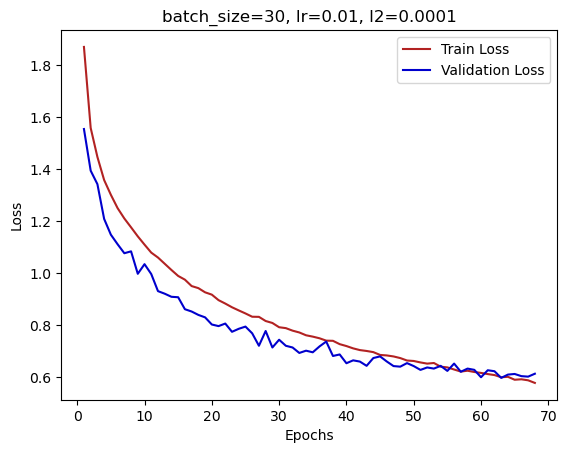

In [94]:
batch_size = 30
lr = 0.01 
l2 = 0.0001
model = CNNNetwork6(0.1, 0.2)
parameters_string = f"batch_size={batch_size}, lr={lr}, l2={l2}"
train_losses, valid_losses = ModelTraining(model, batch_size, lr, l2, num_epochs = 100)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Let's try to increase the batch size

Epoch: 0 | Train Loss: 2.11937, Train Acc: 34.03% |            Validation Loss: 1.84496, Validation Acc: 34.27%
Epoch: 5 | Train Loss: 1.47604, Train Acc: 52.38% |            Validation Loss: 1.33117, Validation Acc: 52.00%
Epoch: 10 | Train Loss: 1.29884, Train Acc: 59.23% |            Validation Loss: 1.15093, Validation Acc: 58.53%
Epoch: 15 | Train Loss: 1.19125, Train Acc: 62.74% |            Validation Loss: 1.06955, Validation Acc: 61.85%
Epoch: 20 | Train Loss: 1.11600, Train Acc: 65.82% |            Validation Loss: 1.00576, Validation Acc: 64.27%
Epoch: 25 | Train Loss: 1.05131, Train Acc: 68.84% |            Validation Loss: 0.93040, Validation Acc: 66.80%
Epoch: 30 | Train Loss: 1.01501, Train Acc: 70.58% |            Validation Loss: 0.89768, Validation Acc: 68.11%
Epoch: 35 | Train Loss: 0.96167, Train Acc: 72.21% |            Validation Loss: 0.85306, Validation Acc: 69.93%
Epoch: 40 | Train Loss: 0.92624, Train Acc: 74.01% |            Validation Loss: 0.81386, Validati

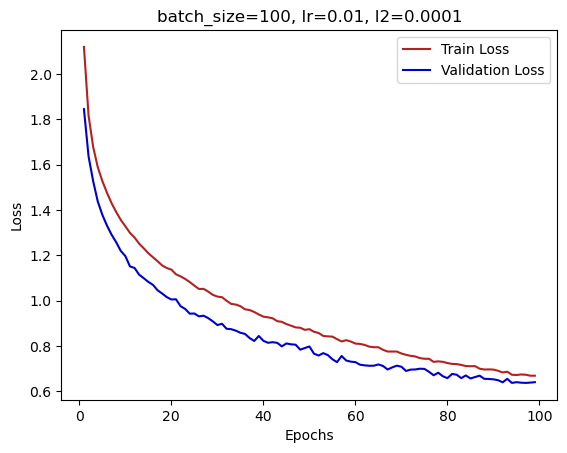

In [95]:
batch_size = 100
lr = 0.01 
l2 = 0.0001
model = CNNNetwork6(0.1, 0.2)
parameters_string = f"batch_size={batch_size}, lr={lr}, l2={l2}"
train_losses, valid_losses = ModelTraining(model, batch_size, lr, l2, num_epochs = 100)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

The best model we got was CNNNetwork6 with batch size=30, lr=0.1, l2=0.0001, fcn dropout=0.1, cnn dropout=0.2 after 65 epochs with around 0.6 loss.

In [99]:
model = CNNNetwork6(0.1, 0.2)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=30, shuffle=True)

loss_fn = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)

for epoch in range(65):

    model.train()
        
    for batch_idx, (data, target) in enumerate(trainloader):

        output_train = model(data)
        loss_train = loss_fn(output_train, target)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
    if epoch%5 == 0:
        print("Running")

Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running


In [100]:
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset))
model.eval()
with torch.inference_mode():
            
    for data_test, target_test in testloader:
        output_test = model(data_test)
        pred_test = torch.softmax(output_test, dim=1).argmax(dim=1)
        loss_test = loss_fn(output_test, target_test)
        acc_test = accuracy_fn(target_test, pred_test)
            
print(f"Validation Loss: {loss_test:.5f}, Validation Acc: {acc_test:.2f}%")

Validation Loss: 0.52599, Validation Acc: 81.66%


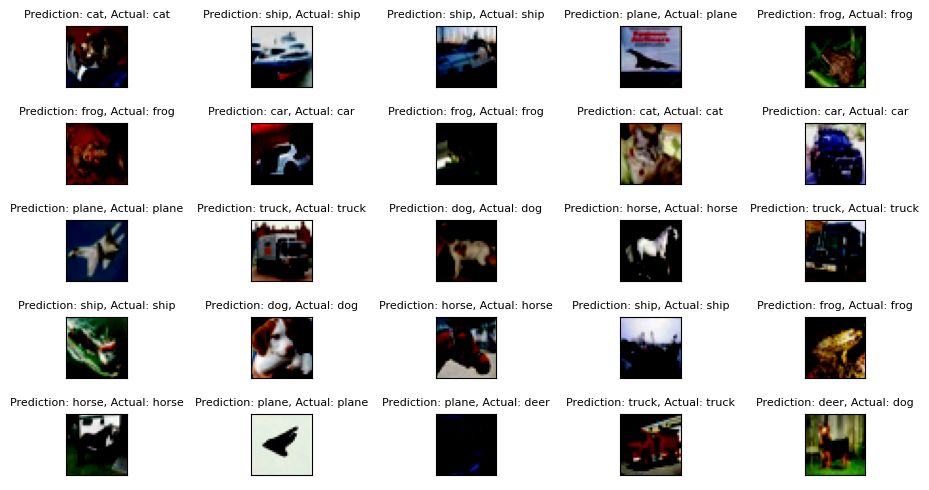

In [122]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
fig = plt.figure(figsize=(10,5))
for idx in np.arange(25):
    img = testset[idx][0]
    ax = fig.add_subplot(5, int(25/5), idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    ax.set_title(f"Prediction: {classes[pred_test[idx]]}, Actual: {classes[target_test[idx]]}", fontsize = 8)
fig.tight_layout()
clear_output();

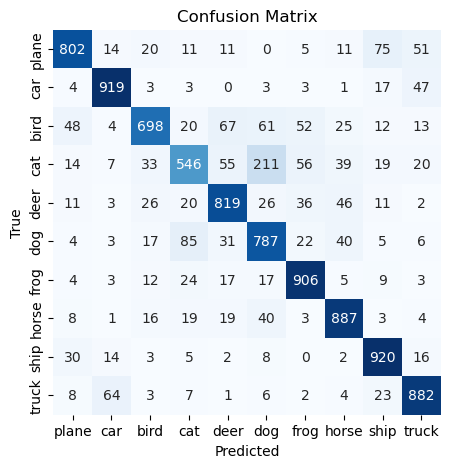

In [127]:
def plot_confusion_matrix(targets, predictions):
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    cm = confusion_matrix(targets, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(target_test, pred_test)

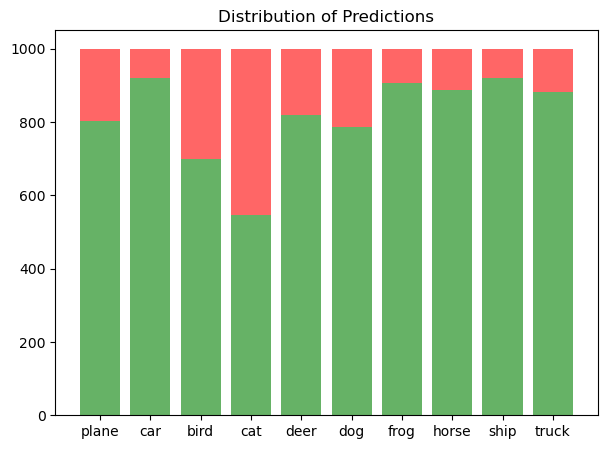

In [128]:
def plot_prediction_histogram(true_labels, predicted_labels):
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    unique_labels = np.unique(true_labels)
    plt.figure(figsize=(7, 5))
    for i, label in enumerate(unique_labels):
        indices = np.where(true_labels == label)
        predicted_counts = np.bincount(predicted_labels[indices], minlength=10)
        correct_counts = predicted_counts[label]
        incorrect_counts = np.sum(predicted_counts) - correct_counts
        x_values = np.array([i])
        plt.bar(x_values, [correct_counts], color='g', label='Correct', alpha=0.6)
        plt.bar(x_values, [incorrect_counts], bottom=[correct_counts], color='r', label='Incorrect', alpha=0.6)
    plt.title('Distribution of Predictions')
    plt.xticks(np.arange(len(unique_labels)), [classes[label] for label in unique_labels])
    plt.show()

plot_prediction_histogram(target_test, pred_test)